# Ask GPT-4v

> Python module for processing image by asking GPT via OpenAI API

In [ ]:
#| default_exp vision.gpt4v

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from IPython.display import Image
import base64
import glob
import json
import openai
import requests

## Process images with GPT

A simple approach to process image with GPT is to encode image as base64 string and ask about its information. Starting with some local images:

In [ ]:
#| eval: false
import os
from pathlib import Path

data_path = Path(os.getenv("LLMCAM_DATA", "../data")).absolute()
files = sorted(glob.glob(f"{data_path}/cap_*.jpg"))
len(files), files[:9]

(551,
 ['/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_15:59:06_Presidentinlinna.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:00:11_Presidentinlinna.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:01:16_Etelasatama.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:02:21_Etelasatama.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:05:31_Olympiaterminaali.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:06:36_Olympiaterminaali.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:07:41_Torni.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:09:51_Tuomiokirkko.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:15:11_Presidentinlinna.jpg'])

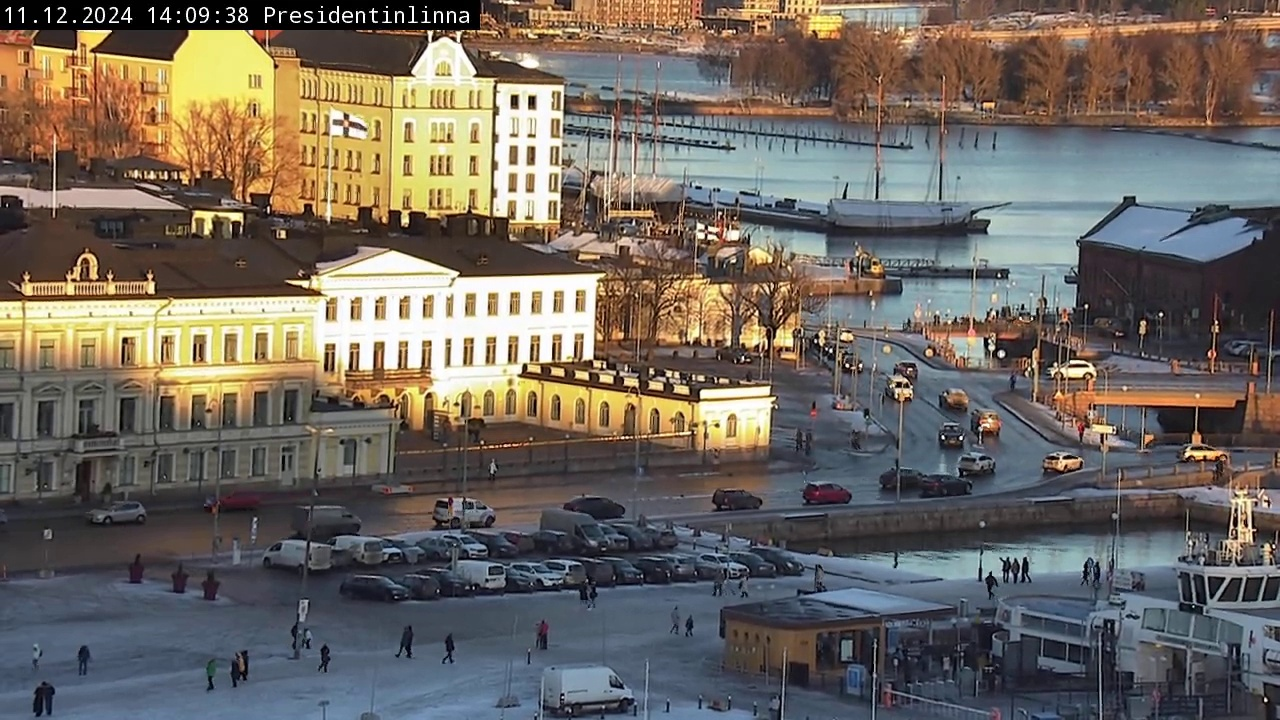

In [ ]:
#| eval: false
Image(files[-1])

In [ ]:
#| export
def encode_image(fname: str):
    """Encode an image file as base64 string"""
    with open(fname, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

In [ ]:
show_doc(encode_image)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/gpt4v.py#L17){target="_blank" style="float:right; font-size:smaller"}

### encode_image

>      encode_image (fname:str)

*Encode an image file as base64 string*

Example of encoding:

In [ ]:
#| eval: false
base64_image = encode_image(files[0])
base64_image[:9]

'/9j/4AAQS'

With the encoded image, we can use OpenAI API to intiate a conversation asking about the image. We can also specify the format of outputs:

In [ ]:
#|export
question = """
    Describe this image quantitatively as many as possible in json format. All the value should numbers.
    
    ##### EXAMPLE OUTPUT FORMAT
    {
        'timestamp': '2024-10-06T19:04:14',
        'location': 'Kauppatori',
        'dimensions': '1280 x 720',
        'building': 10,
        'buildings_height_range': '3-5 stories',
        'car': 5,
        'truck': 2,
        'boat': 4,
        'available_parking_space': 3,
        'street_lights': 20,
        'person': 10,
        'time_of_day': 'evening',
        'artificial_lighting': 'prominent',
        'visibility_clear': True,
        'sky_visible': True,
        'sky_light_conditions': 'dusk',
        'waterbodies_visible': True,
        'waterbodies_type': 'harbor'
    }
    """

In [ ]:
#| eval: false
response = openai.chat.completions.create(
  model="gpt-4o",
  messages=[{
        "role": "user",
        "content": [
            {"type": "text", "text": question,},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encode_image(files[-1])}", "detail":"high",},
            },
        ],
    }],
  max_tokens=300,
)
response.choices[0].message.content

'```json\n{\n    "timestamp": "2024-12-11T14:09:38",\n    "location": "Kauppatori",\n    "dimensions": "1280 x 720",\n    "building": 6,\n    "buildings_height_range": "3-6 stories",\n    "car": 7,\n    "truck": 1,\n    "boat": 2,\n    "available_parking_space": 15,\n    "street_lights": 10,\n    "person": 12,\n    "time_of_day": "afternoon",\n    "artificial_lighting": "minimal",\n    "visibility_clear": true,\n    "sky_visible": true,\n    "sky_light_conditions": "daylight",\n    "waterbodies_visible": true,\n    "waterbodies_type": "harbor"\n}\n```'

It is clear that we need some extra processing steps to convert the JSON-formatted data in strings into Python dictionary.

In [ ]:
#| export
def info(response):
    txt = json.loads(response.json())['choices'][0]['message']['content']
    data = json.loads(txt.replace('```json\n', "").replace('\n```', ""))
    return data

In [ ]:
#| eval: false
info(response)

/tmp/ipykernel_49821/2561472427.py:3: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  txt = json.loads(response.json())['choices'][0]['message']['content']


{'timestamp': '2024-12-11T14:09:38',
 'location': 'Kauppatori',
 'dimensions': '1280 x 720',
 'building': 6,
 'buildings_height_range': '3-6 stories',
 'car': 7,
 'truck': 1,
 'boat': 2,
 'available_parking_space': 15,
 'street_lights': 10,
 'person': 12,
 'time_of_day': 'afternoon',
 'artificial_lighting': 'minimal',
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': 'daylight',
 'waterbodies_visible': True,
 'waterbodies_type': 'harbor'}

Let us summarize this whole process with a single function to be integrated into GPT Function calling. 

In [ ]:
#| export
def ask_gpt4v_about_image_file(
        path:str  # Path to the image file
    ) -> str:  # JSON string with quantitative information
    """Tell all about quantitative information from a given image file"""
    response = openai.chat.completions.create(
      model="gpt-4o",
      messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": question,},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{encode_image(path)}", "detail":"high",},
                },
            ],
        }],
      max_tokens=300,
    )
    return info(response)

In [ ]:
show_doc(ask_gpt4v_about_image_file)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/core/fn_to_fc.py#L41){target="_blank" style="float:right; font-size:smaller"}

### ask_gpt4v_about_image_file

>      ask_gpt4v_about_image_file (path:str)

*Tell all about quantitative information from a given image file*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str | Path to the image file |
| **Returns** | **str** | **JSON string with quantitative information** |

Test with the previous data file:

In [ ]:
#| eval: false
ask_gpt4v_about_image_file(files[-1])

/tmp/ipykernel_49821/2561472427.py:3: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  txt = json.loads(response.json())['choices'][0]['message']['content']


{'timestamp': '2024-12-11T14:09:38',
 'location': 'Presidentinlinna',
 'dimensions': '1280 x 720',
 'building': 10,
 'buildings_height_range': '3-6 stories',
 'car': 10,
 'truck': 1,
 'boat': 3,
 'available_parking_space': 5,
 'street_lights': 15,
 'person': 20,
 'time_of_day': 'afternoon',
 'artificial_lighting': 'minimal',
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': 'daylight',
 'waterbodies_visible': True,
 'waterbodies_type': 'harbor'}

## Simulated GPT workflow

This section tests integrating with our current GPT framework. This function can be used in combination with `ytlive` module:

In [ ]:
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema
from llmcam.vision.ytlive import capture_youtube_live_frame

tools = [
    function_schema(capture_youtube_live_frame, "Youtube Live Capture"),
    function_schema(ask_gpt4v_about_image_file, "GPT4 Vision"),
]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Hi, can you capture a YouTube Live? Use the default link.")
])
complete(messages, tools=tools)
print_msgs(messages)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading mweb player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
[youtube] LMZQ7eFhm58: Downloading m3u8 information
11.12.2024 17:27:23 Tuomiokirkko
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture a YouTube Live? Use the default link.
>> Assistant:
I have captured an image from the default YouTube Live stream. You can find the image at the
following path: `/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_17:27:23_Tuomiokirkko.jpg`.


In [ ]:
#| eval: false
# Continue the conversation and ask about the image file
messages.append(form_msg("user", "Can you extract information about this image?"))
complete(messages, tools=tools)
print_msgs(messages)

/tmp/ipykernel_49821/2561472427.py:3: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  txt = json.loads(response.json())['choices'][0]['message']['content']


>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture a YouTube Live? Use the default link.
>> Assistant:
I have captured an image from the default YouTube Live stream. You can find the image at the
following path: `/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.11_17:27:23_Tuomiokirkko.jpg`.
>> User:
Can you extract information about this image?
>> Assistant:
Here's the information extracted from the image captured:  - **Timestamp**: 2024-12-11 17:27:23 -
**Location**: Tuomiokirkko - **Image Dimensions**: 1280 x 720 pixels - **Buildings Count**: 15 -
**Building Heights**: Range from 3 to 5 stories - **Vehicles**:    - Cars: 0   - Trucks: 0   -
Boats: 0 - **Available Parking Spaces**: 0 - **Street Lights**: 10 - **People**: 5 counted - **Time
of Day**: Evening - **Artificial Lighting**: Prominent in the image - **Visibility**: Clear - **Sky
Conditions**: Visible, nighttime conditions - **Waterbodies**: Not visible  If

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()